In [ ]:
# For Github

---
<a id='intro'></a> 

# 0. Introduction

In this project we will be working with Amazon review data for "groceries" and "gourmet food". The dataset was obtained through https://nijianmo.github.io/amazon/index.html and spans a period of 18 years from 2000-2018. The main objective of the project is to build a recommender system for recommending products to users. 

This project and notebook will deal with analysis of product ratings and review data for Amazon purchases. Two main tasks will be undertaken. The first concerns building a recommender system on the product data while the second concerns using survival analysis to model demand and time-to-next-purchase. The notebook will first give a descriptive overview of the data and present any overall preprocessing choices made with the data - e.g. transformations, only selecting a subset of the data etc.
The notebook will then proceed to the recommender system and survival analysis. Each of these sections will contain a brief introduction to the research questions being investigated as well as a presentation and discussion of the methods, results and future work. The two overarching research questions are as follows:

* To what extent can a recommender system be built to recommend products to users from the Amazon "Grocery and Gourmet Food" dataset and what characterizes the model that performs best?

* Survival

# 1. The dataset #

The dataset used contains reviews and ratings for a wide variety of products sold by Amazon. To limit the analysis we have chosen to focus on the "Groceries and Gourmet Food" category. The data was obtained through https://nijianmo.github.io/amazon/index.html and spans a period of 18 years from 2000-2018. In total, the dataset contains 5.074.160 reviews of products. We have selected a subset corresponding to 153.619 reviews covering 4092 unique products and 73632 unique users. Tables 1 and 2 shows descriptive statistics along with a brief description for the non-continuous and continuous variables respectively.

# 2. Recommender engine

With the dataset having been presented a recommender system will be built. The structure of this section will be as follows:
* 2.1 Build and evaluate the ability of the basic methods introduced in the course in building a recommender system. These methods are: ..

* 2.2 Combine these methods to see if a composite method performs better than the individual methods by themselves
* 2.3 Apply more advanced methods found through litterature review. Of main interest will be building a composite neural network that leverages rating information as well as context and content information about the products.
* 2.4 Discuss which model performs best and why. This step will involve trying to make sense of which products are recommended/disrecommended by the model and why.
* 2.5 Show a few 'proof-of-concept' examples of how the recommender system could function in practice. This step primarily concerns devising a simple solution for problems such as "what if the user doesn't buy the recommended items?". Steps 2.1-2.4 will all have a clear quantitative performance metric (MSE of rating predictions) while the point of step 2.5. is to devise solutions for problems our recommender system might face in real-time shopping situations. Seing as we do not have access to real-time data this step will remain in a 'proof-of-concept' state.

Brief litterature overview:
A brief litterature review was undertaken to find useable resources and guide the work with the recommender system. It was found that a considerable amount of litterature sought to leverage the text contained within reviews as a means of improving recommender systems. The reviews were seen as a potential source of raw implicit feedback (e.g. analyzing the sentiment of the review) as well as a way of extracting more detailed content about the products. The texts typically sought to combine LDA and MF (matrix factorization) either through bayesian approaches or neural networks. The two main .. we have used..

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
from tensorflow.keras import models, layers, utils
import keras_tuner as kt
from tensorflow import keras
dfs=pd.read_csv("preprocessed.csv")
dfs=dfs.iloc[:,3:]

# Preparing the data #

'Double reviews':
In total 493 (0.5%) reviews were "doubles" of a former review - duplicates meaning that the same person reviewed the same product with the only difference being the review text. Manual inspection of these 'double'-reviews showed that they were likely due to the reviewer making small changes in the text of the review - e.g. change from 'excellemt product' to 'excellent product' - and the 'double' reviews were typically close in time - typically on the same day. Because so few reviews are affected, in case of double reviews, only the most recent review was kept. If it had been the case that the 'double' reviews were due to the person buying the same product 6 months later and changing his/her opinion then the procedure should've been different. However, as this does not appear to be the case we will not spend more time analyzing 'double' reviews.

In order to prepare the data for analysis the following steps are taken. The code for these preparation steps are contained in 'Preparation.ipynb'.
* Identify products with multiple reviews by the same user. Keep only the most recent review.
* Recode the 'bottomcat' variable such that categories with less than 40 reviews are categorized as 'other'.
* Dummy-encode the 'bottomcat' variable.
* Discretize ratings based on >= 4 as cutoff-point.
* Standardize continuous features.
* Re-enumerate user and product IDs for use with the Keras embedding layer
* Create both a product X user ratings matrix and a long-form [user, product, ratings, features, context] dataframe. The format of these dataframes is shown below.
* Preprocess review text (remove stopwords etc.)

# Create a DF ready for CF-analysis
First, a user-item ratings matrix is created. Non-nan values are scaled from 0 to 5 to 0 to 1 in anticipation of the neural networks being used.

20% of the data is kept for testing.

In [2]:
%run DataPreprocessing.ipynb

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Frede\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Frede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Simple MF model #
Figure x shows the 3 models which will be created in the following sequences of code. The first model is a baseline MF model created through Keras. An embedding layer is created for the users and items respectively. Currently, the embedding output dimension is set to 50.
The output is a linear function of the dot product of the two embedding layers and the loss is set to MSE. The y for which the MSE should be minimized will be the actual ratings.

In [ ]:
embeddings_size = 50
usr, prd = df_cf.shape[0], df_cf.shape[1]

# Create embedding layer for users
# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Create embedding layer for products
# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Compute dot product of the embedding layers
# Product (,1) values[-1,1]
QP = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Add output layer which takes as input QP
# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(QP)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
#model.summary()

In [ ]:
# The NN looks as follows
#utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [4]:
%run ABAUtils.ipynb

In order for the model to work with tensorflow syntex the "IDs" of the user and item must be transformed to a number. This is done in the following code and a list of the original item/product IDs are saved for later use.

In [ ]:
# train
training = model.fit(x=[trainf['user'], trainf['product']], y=trainf["overall"], 
                     epochs=10, batch_size=128, shuffle=True, verbose=1, validation_split=0.3)
model = training.model

In [ ]:
utils_plot_keras_training(training)

In [ ]:
# Test
testf['yhat'] = model.predict([testf["user"], testf["product"]])
test
np.mean((testf['overall']-testf['yhat'])**2)

In [ ]:
testf['overall'].hist(), testf['yhat'].hist()

# Performance metrics #

The following metrics will be used to provide an overview of the performance of the different models.
* MSE (or MAE) - i.e. measures of how accurately the value of the ratings are predicted.
* Raw classification measures - classification measures assuming that a predicted rating of >= 4 constitutes a success (purchase).
* Scaled classification measures - classification measures adjusted for the distribution of the predicted ratings. I.e. if 80% of the observed ratings are >= 4, then a predicted rating is considered a success if it is above the 20'th percentile of the predicted ratings (i.e. among the top 80% of predicted ratings).
* Ordering of products - Are the products with the highest predicted ratings also the products bought/reviewed?
The loss function of the models will only seek to optimize some of the performance metrics. Therefore, some of the metrics (such as 'ordering of products') is only used as ways of helping interpret the performance of the model.

In [ ]:
embeddings_size = 50
usr, prd = df_cf.shape[0], df_cf.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
#model.summary()

In [ ]:
# train
training = model.fit(x=[trainf["user"], trainf["product"]], y=trainf["overall"], 
                     epochs=1000, batch_size=128, shuffle=True, verbose=1, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# Test
testf['yhat'] = model.predict([testf["user"], testf["product"]])
np.mean((testf['overall']-testf['yhat'])**2)

In [ ]:
testf['overall'].hist(), testf['yhat'].hist()

# Adding context and product features #

Fuld NN her.

In [116]:
df_full_train=trainf.drop(columns=['reviewText', 'reviewText_cleaned', 'disc_rating','neg','pos','compound','neu','unixReviewTime'])
df_full_test=testf.drop(columns=['reviewText', 'reviewText_cleaned', 'disc_rating','neg','pos','compound','neu','unixReviewTime'])

Context:
* unixReviewTime

Content:
* verified
* vote
* price
* review_length
* bottomcats

In [ ]:
df_full_train['verified']=df_full_train['verified'].astype(float)
df_full_test['verified']=df_full_test['verified'].astype(float)

In [121]:
df_full_test

,user,product,overall,verified,vote,price,review_length,bottomcat_other_Agave Nectar & Syrup,bottomcat_other_Allspice,bottomcat_other_Almonds,...,bottomcat_other_Wasabi,bottomcat_other_Wasabi Peas,bottomcat_other_Water,bottomcat_other_Wheat,bottomcat_other_Wheat Flours & Meals,bottomcat_other_White,bottomcat_other_Wild,bottomcat_other_Xylitol,bottomcat_other_Yellow Mustard,bottomcat_other_other
0,2,2089,5.0,1.0,-0.297063,-6.675437e-01,-0.589158,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2105,5.0,0.0,-0.297063,-3.671440e-01,-0.997660,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,2011,4.0,1.0,0.198986,-4.759389e-16,-0.566957,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2054,4.0,1.0,-0.297063,-9.266154e-01,-0.922176,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2189,4.0,1.0,-0.297063,-4.759389e-16,-0.469272,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,1404,2263,5.0,1.0,-0.297063,-4.759389e-16,-0.926616,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1467,1404,2272,5.0,1.0,-0.297063,-4.759389e-16,-0.713485,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1468,1404,2278,5.0,1.0,-0.297063,-4.759389e-16,-0.513674,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1469,1404,2282,5.0,1.0,-0.297063,-4.759389e-16,-0.749007,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
embeddings_size = 50
usr, prd = df_cf.shape[0], df_cf.shape[1]
ctx =  324 # time
feat = 1 # price, vote

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
def build_model(hp):
    xusers_in = layers.Input(name="xusers_in", shape=(1,))
    xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

    # A) Matrix Factorization
    ## embeddings and reshape
    cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
    cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
    ## embeddings and reshape
    cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
    cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
    ## product
    cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

    # B) Neural Network
    ## embeddings and reshape
    nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
    nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
    ## embeddings and reshape
    nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
    nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
    ## concat and dense
    nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
    nn_xx = layers.Dense(name="nn_xx",  units=hp.Int("units", min_value=2, max_value=100, step=1),
            activation="relu")(nn_xx)

    ########################################## CONTENT BASED ###################################################
    # Product Features
    features_in = layers.Input(name="features_in", shape=(feat,))
    features_x = layers.Dense(name="features_x", units=hp.Int("units", min_value=1, max_value=2, step=1), activation='relu')(features_in)

    ########################################## KNOWLEDGE BASED #################################################
    # Context
    contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
    context_x = layers.Dense(name="context_x",  units=hp.Int("units", min_value=300, max_value=400, step=2), activation='relu')(contexts_in)

    ########################################## OUTPUT ###################################################
    # Merge all
    y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
    y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

    # Compile
    model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
    return model
    #model.summary()

In [146]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="mean_absolute_percentage_error",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="tuner",
    project_name="amazon_recommender",
)

In [147]:
tuner.search(x=[df_full_train["user"], df_full_train["product"],df_full_train['price'], pd.concat([df_full_train[['price']],df_full_train.iloc[:,7:]],axis=1)],
                     y=df_full_train["overall"], 
                     epochs=30, shuffle=True, verbose=1, validation_split=0.3)

Trial 5 Complete [00h 00m 19s]
mean_absolute_percentage_error: 4.797012567520142

Best mean_absolute_percentage_error So Far: 4.743939161300659
Total elapsed time: 00h 01m 39s
INFO:tensorflow:Oracle triggered exit


In [154]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])

In [160]:
# train with the best hyper parameters
model.fit(x=[df_full_train["user"], df_full_train["product"],
                        df_full_train['price'], pd.concat([df_full_train[['price']],df_full_train.iloc[:,7:]],axis=1)],
                     y=df_full_train["overall"], 
                     epochs=100, shuffle=True, verbose=0, validation_split=0.3)

In [161]:
# Test
del df_full_test['yhat']
df_full_test['yhat'] = model.predict([df_full_test["user"], df_full_test["product"],
                                       df_full_test['price'],
                                      pd.concat([df_full_test[['price']],df_full_test.iloc[:,7:]],axis=1)])

In [162]:
np.mean((df_full_test['overall']-df_full_test['yhat'])**2)

1.4797235344567463

In [157]:
np.mean((df_full_test['overall']-df_full_test['yhat'])**2)

1.480321654293059

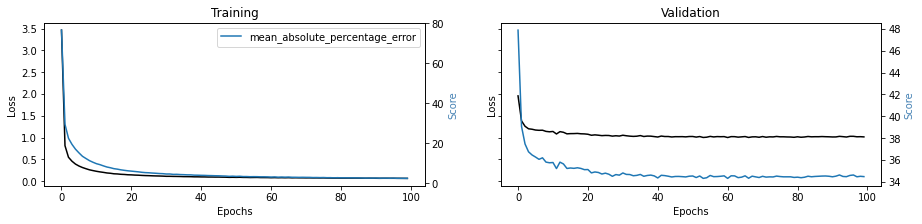

In [158]:
utils_plot_keras_training(training)

(<AxesSubplot:>, <AxesSubplot:>)

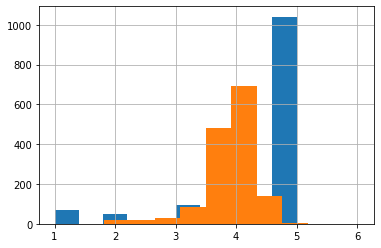

In [163]:
df_full_test['overall'].hist(), df_full_test['yhat'].hist()

# Other metrics #

* Change to classification - predict 5-star reviews
* Classification metrics as performance measures. Doesn't neccesarily have to follow distribution of original data.
* Assign greater penalty to overpredictions, especially overpredictions of more than 1
* Weigh sampling method?
* How to interpret the NN

MSE, classification.
Bought 4 products, are these 4 products also the 4 highest rated or among the highest rated items.

In [ ]:
df_full_test[df_full_test['overall']<=2]

In [ ]:
df_full_test.loc[df_full_test['user']==1400,:]